<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Aggregation and Grouping

An essential piece of analysis of large data is efficient summarization: computing aggregations like ``sum()``, ``mean()``, ``median()``, ``min()``, and ``max()``, in which a single number gives insight into the nature of a potentially large dataset.
In this section, we'll explore aggregations in Pandas, from simple operations akin to what we've seen on NumPy arrays, to more sophisticated operations based on the concept of a ``groupby``.

For convenience, we'll use the same ``display`` magic function that we've seen in previous sections:

In [1]:
import numpy as np
import pandas as pd

## Planets Data

Here we will use the Planets dataset, available via the [Seaborn package](http://seaborn.pydata.org/) (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)).
It gives information on planets that astronomers have discovered around other stars (known as *extrasolar planets* or *exoplanets* for short). It can be downloaded with a simple Seaborn command:

https://exoplanets.nasa.gov/

In [2]:
import seaborn as sns

C:\Users\NFSI291\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [8]:
planets.head()
planets.shape

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


(1035, 6)

This has some details on the 1,000+ extrasolar planets discovered up to 2014.

Pandas ``Series`` and ``DataFrame``s include all of the common aggregates mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb); in addition, there is a convenience method ``describe()`` that computes several common aggregates for each column and returns the result.
Let's use this on the Planets data, for now dropping rows with missing values:

In [9]:
planets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method          1035 non-null   object 
 1   number          1035 non-null   int64  
 2   orbital_period  992 non-null    float64
 3   mass            513 non-null    float64
 4   distance        808 non-null    float64
 5   year            1035 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 48.6+ KB


In [6]:
planets.describe()

,number,orbital_period,mass,distance,year
count,1035.000000,992.000000,513.000000,808.000000,1035.000000
mean,1.785507,2002.917596,2.638161,264.069282,2009.070531
std,1.240976,26014.728304,3.818617,733.116493,3.972567
min,1.000000,0.090706,0.003600,1.350000,1989.000000
25%,1.000000,5.442540,0.229000,32.560000,2007.000000
50%,1.000000,39.979500,1.260000,55.250000,2010.000000
75%,2.000000,526.005000,3.040000,178.500000,2012.000000
max,7.000000,730000.000000,25.000000,8500.000000,2014.000000


In [10]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


This can be a useful way to begin understanding the overall properties of a dataset.
For example, we see in the ``year`` column that although exoplanets were discovered as far back as 1989, half of all known expolanets were not discovered until 2010 or after.
This is largely thanks to the *Kepler* mission, which is a space-based telescope specifically designed for finding eclipsing planets around other stars.

The following table summarizes some other built-in Pandas aggregations:

| Aggregation              | Description                     |
|--------------------------|---------------------------------|
| ``count()``              | Total number of items           |
| ``first()``, ``last()``  | First and last item             |
| ``mean()``, ``median()`` | Mean and median                 |
| ``min()``, ``max()``     | Minimum and maximum             |
| ``std()``, ``var()``     | Standard deviation and variance |
| ``mad()``                | Mean absolute deviation         |
| ``prod()``               | Product of all items            |
| ``sum()``                | Sum of all items                |

These are all methods of ``DataFrame`` and ``Series`` objects.

To go deeper into the data, however, simple aggregates are often not enough.
The next level of data summarization is the ``groupby`` operation, which allows you to quickly and efficiently compute aggregates on subsets of data.

## GroupBy: Split, Apply, Combine

Simple aggregations can give you a flavor of your dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called ``groupby`` operation.
The name "group by" comes from a command in the SQL database language, but it is perhaps more illuminative to think of it in the terms first coined by Hadley Wickham of Rstats fame: *split, apply, combine*.

### Split, apply, combine

A canonical example of this split-apply-combine operation, where the "apply" is a summation aggregation, is illustrated in this figure:

![](figures/03.08-split-apply-combine.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Split-Apply-Combine)

This makes clear what the ``groupby`` accomplishes:

- The *split* step involves breaking up and grouping a ``DataFrame`` depending on the value of the specified key.
- The *apply* step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The *combine* step merges the results of these operations into an output array.

While this could certainly be done manually using some combination of the masking, aggregation, and merging commands covered earlier, an important realization is that *the intermediate splits do not need to be explicitly instantiated*. Rather, the ``GroupBy`` can (often) do this in a single pass over the data, updating the sum, mean, count, min, or other aggregate for each group along the way.
The power of the ``GroupBy`` is that it abstracts away these steps: the user need not think about *how* the computation is done under the hood, but rather thinks about the *operation as a whole*.

As a concrete example, let's take a look at using Pandas for the computation shown in this diagram.
We'll start by creating the input ``DataFrame``:

In [11]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


In [12]:
df.sort_values('key')

,key,data
0,A,0
3,A,3
1,B,1
4,B,4
2,C,2
5,C,5


The most basic split-apply-combine operation can be computed with the ``groupby()`` method of ``DataFrame``s, passing the name of the desired key column:

In [13]:
df.groupby('key')

Notice that what is returned is not a set of ``DataFrame``s, but a ``DataFrameGroupBy`` object.
This object is where the magic is: you can think of it as a special view of the ``DataFrame``, which is poised to dig into the groups but does no actual computation until the aggregation is applied.
This "lazy evaluation" approach means that common aggregates can be implemented very efficiently in a way that is almost transparent to the user.

To produce a result, we can apply an aggregate to this ``DataFrameGroupBy`` object, which will perform the appropriate apply/combine steps to produce the desired result:

In [24]:
for (i, j) in df.groupby('key'):
    i
    j.sum()

'A'

key     AA
data     3
dtype: object

'B'

key     BB
data     5
dtype: object

'C'

key     CC
data     7
dtype: object

In [21]:
df.groupby('key').sum()
df.groupby('key').count()

,data
key,
A,3
B,5
C,7


,data
key,
A,2
B,2
C,2


In [25]:
df.groupby('key').median()
df.groupby('key').max()

,data
key,
A,1.5
B,2.5
C,3.5


,data
key,
A,3
B,4
C,5


The ``sum()`` method is just one possibility here; you can apply virtually any common Pandas or NumPy aggregation function, as well as virtually any valid ``DataFrame`` operation, as we will see in the following discussion.

### The GroupBy object

The ``GroupBy`` object is a very flexible abstraction.
In many ways, you can simply treat it as if it's a collection of ``DataFrame``s, and it does the difficult things under the hood. Let's see some examples using the Planets data.

Perhaps the most important operations made available by a ``GroupBy`` are *aggregate*, *filter*, *transform*, and *apply*.
We'll discuss each of these more fully in ["Aggregate, Filter, Transform, Apply"](#Aggregate,-Filter,-Transform,-Apply), but before that let's introduce some of the other functionality that can be used with the basic ``GroupBy`` operation.

#### Column indexing

The ``GroupBy`` object supports column indexing in the same way as the ``DataFrame``, and returns a modified ``GroupBy`` object.
For example:

In [29]:
for (i, j) in planets.groupby('method'):
    i
    j.head(2)

'Astrometry'

,method,number,orbital_period,mass,distance,year
113,Astrometry,1,246.36,NaN,20.77,2013
537,Astrometry,1,1016.00,NaN,14.98,2010


'Eclipse Timing Variations'

,method,number,orbital_period,mass,distance,year
32,Eclipse Timing Variations,1,10220.0,6.05,NaN,2009
37,Eclipse Timing Variations,2,5767.0,NaN,130.72,2008


'Imaging'

,method,number,orbital_period,mass,distance,year
29,Imaging,1,NaN,NaN,45.52,2005
30,Imaging,1,NaN,NaN,165.00,2007


'Microlensing'

,method,number,orbital_period,mass,distance,year
902,Microlensing,1,NaN,NaN,NaN,2008
903,Microlensing,1,NaN,NaN,NaN,2008


'Orbital Brightness Modulation'

,method,number,orbital_period,mass,distance,year
787,Orbital Brightness Modulation,2,0.240104,NaN,1180.0,2011
788,Orbital Brightness Modulation,2,0.342887,NaN,1180.0,2011


'Pulsar Timing'

,method,number,orbital_period,mass,distance,year
941,Pulsar Timing,3,25.2620,NaN,NaN,1992
942,Pulsar Timing,3,66.5419,NaN,NaN,1992


'Pulsation Timing Variations'

,method,number,orbital_period,mass,distance,year
958,Pulsation Timing Variations,1,1170.0,NaN,NaN,2007


'Radial Velocity'

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008


'Transit'

,method,number,orbital_period,mass,distance,year
91,Transit,1,1.508956,NaN,NaN,2008
92,Transit,1,1.742994,NaN,200.0,2008


'Transit Timing Variations'

,method,number,orbital_period,mass,distance,year
680,Transit Timing Variations,2,160.000,NaN,2119.0,2011
736,Transit Timing Variations,2,57.011,NaN,855.0,2012


In [32]:
for (i, j) in planets.groupby('method')['orbital_period']:
    j.head()
    type(j)

113     246.36
537    1016.00
Name: orbital_period, dtype: float64

pandas.core.series.Series

32    10220.00
37     5767.00
38     3321.00
39     5573.55
40     2883.50
Name: orbital_period, dtype: float64

pandas.core.series.Series

29   NaN
30   NaN
31   NaN
33   NaN
34   NaN
Name: orbital_period, dtype: float64

pandas.core.series.Series

902       NaN
903       NaN
904       NaN
905       NaN
906    2780.0
Name: orbital_period, dtype: float64

pandas.core.series.Series

787    0.240104
788    0.342887
792    1.544929
Name: orbital_period, dtype: float64

pandas.core.series.Series

941       25.262000
942       66.541900
943       98.211400
944    36525.000000
945        0.090706
Name: orbital_period, dtype: float64

pandas.core.series.Series

958    1170.0
Name: orbital_period, dtype: float64

pandas.core.series.Series

0    269.300
1    874.774
2    763.000
3    326.030
4    516.220
Name: orbital_period, dtype: float64

pandas.core.series.Series

91    1.508956
92    1.742994
93    4.256800
94    9.202050
95    4.037896
Name: orbital_period, dtype: float64

pandas.core.series.Series

680    160.0000
736     57.0110
749         NaN
813     22.3395
Name: orbital_period, dtype: float64

pandas.core.series.Series

Here we've selected a particular ``Series`` group from the original ``DataFrame`` group by reference to its column name.
As with the ``GroupBy`` object, no computation is done until we call some aggregate on the object:

In [33]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

This gives an idea of the general scale of orbital periods (in days) that each method is sensitive to.

#### Iteration over groups

The ``GroupBy`` object supports direct iteration over the groups, returning each group as a ``Series`` or ``DataFrame``:

In [35]:
for i in [1,2,3,4]:
    i

1

2

3

4

In [36]:
for (method, group) in planets.groupby('method'):
    print(f'{method:30s} shape={group.shape}')
    group.head()

Astrometry                     shape=(2, 6)


,method,number,orbital_period,mass,distance,year
113,Astrometry,1,246.36,NaN,20.77,2013
537,Astrometry,1,1016.00,NaN,14.98,2010


Eclipse Timing Variations      shape=(9, 6)


,method,number,orbital_period,mass,distance,year
32,Eclipse Timing Variations,1,10220.00,6.05,NaN,2009
37,Eclipse Timing Variations,2,5767.00,NaN,130.72,2008
38,Eclipse Timing Variations,2,3321.00,NaN,130.72,2008
39,Eclipse Timing Variations,2,5573.55,NaN,500.00,2010
40,Eclipse Timing Variations,2,2883.50,NaN,500.00,2010


Imaging                        shape=(38, 6)


,method,number,orbital_period,mass,distance,year
29,Imaging,1,NaN,NaN,45.52,2005
30,Imaging,1,NaN,NaN,165.00,2007
31,Imaging,1,NaN,NaN,140.00,2004
33,Imaging,1,NaN,NaN,NaN,2008
34,Imaging,1,NaN,NaN,145.00,2013


Microlensing                   shape=(23, 6)


,method,number,orbital_period,mass,distance,year
902,Microlensing,1,NaN,NaN,NaN,2008
903,Microlensing,1,NaN,NaN,NaN,2008
904,Microlensing,1,NaN,NaN,NaN,2009
905,Microlensing,1,NaN,NaN,3600.0,2013
906,Microlensing,1,2780.0,NaN,NaN,2011


Orbital Brightness Modulation  shape=(3, 6)


,method,number,orbital_period,mass,distance,year
787,Orbital Brightness Modulation,2,0.240104,NaN,1180.0,2011
788,Orbital Brightness Modulation,2,0.342887,NaN,1180.0,2011
792,Orbital Brightness Modulation,1,1.544929,NaN,NaN,2013


Pulsar Timing                  shape=(5, 6)


,method,number,orbital_period,mass,distance,year
941,Pulsar Timing,3,25.262000,NaN,NaN,1992
942,Pulsar Timing,3,66.541900,NaN,NaN,1992
943,Pulsar Timing,3,98.211400,NaN,NaN,1994
944,Pulsar Timing,1,36525.000000,NaN,NaN,2003
945,Pulsar Timing,1,0.090706,NaN,1200.0,2011


Pulsation Timing Variations    shape=(1, 6)


,method,number,orbital_period,mass,distance,year
958,Pulsation Timing Variations,1,1170.0,NaN,NaN,2007


Radial Velocity                shape=(553, 6)


,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


Transit                        shape=(397, 6)


,method,number,orbital_period,mass,distance,year
91,Transit,1,1.508956,NaN,NaN,2008
92,Transit,1,1.742994,NaN,200.0,2008
93,Transit,1,4.256800,NaN,680.0,2008
94,Transit,1,9.202050,NaN,NaN,2008
95,Transit,1,4.037896,NaN,NaN,2009


Transit Timing Variations      shape=(4, 6)


,method,number,orbital_period,mass,distance,year
680,Transit Timing Variations,2,160.0000,NaN,2119.0,2011
736,Transit Timing Variations,2,57.0110,NaN,855.0,2012
749,Transit Timing Variations,3,NaN,NaN,NaN,2014
813,Transit Timing Variations,2,22.3395,NaN,339.0,2013


This can be useful for doing certain things manually, though it is often much faster to use the built-in ``apply`` functionality, which we will discuss momentarily.

#### Dispatch methods

Through some Python class magic, any method not explicitly implemented by the ``GroupBy`` object will be passed through and called on the groups, whether they are ``DataFrame`` or ``Series`` objects.
For example, you can use the ``describe()`` method of ``DataFrame``s to perform a set of aggregations that describe each group in the data:

In [37]:
planets.groupby(['method'])['year'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
Astrometry,2.0,2011.500000,2.121320,2010.0,2010.75,2011.5,2012.25,2013.0
Eclipse Timing Variations,9.0,2010.000000,1.414214,2008.0,2009.00,2010.0,2011.00,2012.0
Imaging,38.0,2009.131579,2.781901,2004.0,2008.00,2009.0,2011.00,2013.0
Microlensing,23.0,2009.782609,2.859697,2004.0,2008.00,2010.0,2012.00,2013.0
Orbital Brightness Modulation,3.0,2011.666667,1.154701,2011.0,2011.00,2011.0,2012.00,2013.0
Pulsar Timing,5.0,1998.400000,8.384510,1992.0,1992.00,1994.0,2003.00,2011.0
Pulsation Timing Variations,1.0,2007.000000,NaN,2007.0,2007.00,2007.0,2007.00,2007.0
Radial Velocity,553.0,2007.518987,4.249052,1989.0,2005.00,2009.0,2011.00,2014.0
Transit,397.0,2011.236776,2.077867,2002.0,2010.00,2012.0,2013.00,2014.0


Looking at this table helps us to better understand the data: for example, the vast majority of planets have been discovered by the Radial Velocity and Transit methods, though the latter only became common (due to new, more accurate telescopes) in the last decade.
The newest methods seem to be Transit Timing Variation and Orbital Brightness Modulation, which were not used to discover a new planet until 2011.

This is just one example of the utility of dispatch methods.
Notice that they are applied *to each individual group*, and the results are then combined within ``GroupBy`` and returned.
Again, any valid ``DataFrame``/``Series`` method can be used on the corresponding ``GroupBy`` object, which allows for some very flexible and powerful operations!

## 1. groupby value_counts 방법

In [38]:
planets

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300000,7.10,77.40,2006
1,Radial Velocity,1,874.774000,2.21,56.95,2008
2,Radial Velocity,1,763.000000,2.60,19.84,2011
3,Radial Velocity,1,326.030000,19.40,110.62,2007
4,Radial Velocity,1,516.220000,10.50,119.47,2009
...,...,...,...,...,...,...
1030,Transit,1,3.941507,NaN,172.00,2006
1031,Transit,1,2.615864,NaN,148.00,2007
1032,Transit,1,3.191524,NaN,174.00,2007
1033,Transit,1,4.125083,NaN,293.00,2008


In [39]:
planets.columns
planets.nunique()

Index(['method', 'number', 'orbital_period', 'mass', 'distance', 'year'], dtype='object')

method             10
number              7
orbital_period    988
mass              381
distance          552
year               23
dtype: int64

In [40]:
planets.groupby('method')['year'].value_counts()

method                     year
Astrometry                 2010    1
                           2013    1
Eclipse Timing Variations  2011    3
                           2008    2
                           2010    2
                                  ..
Transit                    2002    1
Transit Timing Variations  2011    1
                           2012    1
                           2013    1
                           2014    1
Name: year, Length: 69, dtype: int64

In [41]:
planets.groupby('method')['year'].value_counts().unstack()

year,1989,1992,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
method,,,,,,,,,,,,,,,,,,,,,
Astrometry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN
Eclipse Timing Variations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,1.0,2.0,3.0,1.0,NaN,NaN
Imaging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,4.0,1.0,8.0,3.0,6.0,3.0,2.0,7.0,NaN
Microlensing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,NaN,4.0,2.0,2.0,1.0,6.0,4.0,NaN
Orbital Brightness Modulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN
Pulsar Timing,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Pulsation Timing Variations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Radial Velocity,1.0,NaN,NaN,1.0,6.0,1.0,5.0,15.0,16.0,12.0,...,36.0,21.0,35.0,43.0,74.0,43.0,94.0,38.0,29.0,11.0
Transit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,16.0,17.0,18.0,48.0,80.0,92.0,75.0,40.0


In [45]:
planets.groupby('method')['year'].value_counts().unstack().fillna(0)

year,1989,1992,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
method,,,,,,,,,,,,,,,,,,,,,
Astrometry,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
Eclipse Timing Variations,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1.0,2.0,3.0,1.0,0.0,0.0
Imaging,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,1.0,8.0,3.0,6.0,3.0,2.0,7.0,0.0
Microlensing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,4.0,2.0,2.0,1.0,6.0,4.0,0.0
Orbital Brightness Modulation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
Pulsar Timing,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Pulsation Timing Variations,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Radial Velocity,1.0,0.0,0.0,1.0,6.0,1.0,5.0,15.0,16.0,12.0,...,36.0,21.0,35.0,43.0,74.0,43.0,94.0,38.0,29.0,11.0
Transit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,16.0,17.0,18.0,48.0,80.0,92.0,75.0,40.0


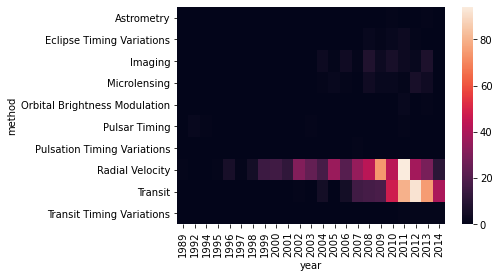

In [43]:
data = planets.groupby('method')['year'].value_counts().unstack().fillna(0)
ax = sns.heatmap(data)

## 2. pd.crosstab 형태로 변환
Odd ratio, Relative Risk 구할 때 편리

In [44]:
pd.crosstab(planets['method'], planets['year'])

year,1989,1992,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
method,,,,,,,,,,,,,,,,,,,,,
Astrometry,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
Eclipse Timing Variations,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,2,3,1,0,0
Imaging,0,0,0,0,0,0,0,0,0,0,...,1,4,1,8,3,6,3,2,7,0
Microlensing,0,0,0,0,0,0,0,0,0,0,...,2,1,0,4,2,2,1,6,4,0
Orbital Brightness Modulation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,1,0
Pulsar Timing,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Pulsation Timing Variations,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Radial Velocity,1,0,0,1,6,1,5,15,16,12,...,36,21,35,43,74,43,94,38,29,11
Transit,0,0,0,0,0,0,0,0,0,0,...,0,5,16,17,18,48,80,92,75,40


## 3. pivot_table 형태로 변환

In [46]:
planets.columns
planets.head(3)

Index(['method', 'number', 'orbital_period', 'mass', 'distance', 'year'], dtype='object')

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011


In [48]:
planets.pivot_table(values='number', index='method', columns='year').fillna(0)

year,1989,1992,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
method,,,,,,,,,,,,,,,,,,,,,
Astrometry,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
Eclipse Timing Variations,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,...,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,1.666667,1.000000,0.000000,0.000000
Imaging,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,...,1.000000,1.000000,1.000000,2.125000,1.000000,1.500000,1.000000,1.000000,1.000000,0.000000
Microlensing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,...,1.000000,1.000000,0.000000,1.500000,1.000000,1.000000,1.000000,1.333333,1.000000,0.000000
Orbital Brightness Modulation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000
Pulsar Timing,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
Pulsation Timing Variations,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Radial Velocity,1.0,0.0,0.0,1.0,2.5,1.0,2.2,1.6,1.6875,1.25,...,1.694444,1.571429,1.342857,1.767442,1.418919,2.139535,1.872340,1.842105,2.241379,1.909091
Transit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00,...,0.000000,1.000000,1.000000,1.000000,1.111111,1.770833,2.025000,1.902174,2.626667,2.325000


In [49]:
planets.pivot_table(values=['number'], index='method', columns='year', aggfunc='mean').fillna(0)

number                                     \
year                            1989 1992 1994 1995 1996 1997 1998 1999   
method                                                                    
Astrometry                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Eclipse Timing Variations        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Imaging                          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Microlensing                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Orbital Brightness Modulation    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Pulsar Timing                    0.0  3.0  3.0  0.0  0.0  0.0  0.0  0.0   
Pulsation Timing Variations      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Radial Velocity                  1.0  0.0  0.0  1.0  2.5  1.0  2.2  1.6   
Transit                          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Transit Timing Variations        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                             ...                      \
year                             2000  2001  ...      2005      2006   
method                                       ...                       
Astrometry                     0.0000  0.00  ...  0.000000  0.000000   
Eclipse Timing Variations      0.0000  0.00  ...  0.000000  0.000000   
Imaging                        0.0000  0.00  ...  1.000000  1.000000   
Microlensing                   0.0000  0.00  ...  1.000000  1.000000   
Orbital Brightness Modulation  0.0000  0.00  ...  0.000000  0.000000   
Pulsar Timing                  0.0000  0.00  ...  0.000000  0.000000   
Pulsation Timing Variations    0.0000  0.00  ...  0.000000  0.000000   
Radial Velocity                1.6875  1.25  ...  1.694444  1.571429   
Transit                        0.0000  0.00  ...  0.000000  1.000000   
Transit Timing Variations      0.0000  0.00  ...  0.000000  0.000000   

                                                                       \
year                               2007      2008      2009      2010   
method                                                                  
Astrometry                     0.000000  0.000000  0.000000  1.000000   
Eclipse Timing Variations      0.000000  2.000000  1.000000  2.000000   
Imaging                        1.000000  2.125000  1.000000  1.500000   
Microlensing                   0.000000  1.500000  1.000000  1.000000   
Orbital Brightness Modulation  0.000000  0.000000  0.000000  0.000000   
Pulsar Timing                  0.000000  0.000000  0.000000  0.000000   
Pulsation Timing Variations    1.000000  0.000000  0.000000  0.000000   
Radial Velocity                1.342857  1.767442  1.418919  2.139535   
Transit                        1.000000  1.000000  1.111111  1.770833   
Transit Timing Variations      0.000000  0.000000  0.000000  0.000000   

                                                                       
year                               2011      2012      2013      2014  
method                                                                 
Astrometry                     0.000000  0.000000  1.000000  0.000000  
Eclipse Timing Variations      1.666667  1.000000  0.000000  0.000000  
Imaging                        1.000000  1.000000  1.000000  0.000000  
Microlensing                   1.000000  1.333333  1.000000  0.000000  
Orbital Brightness Modulation  2.000000  0.000000  1.000000  0.000000  
Pulsar Timing                  1.000000  0.000000  0.000000  0.000000  
Pulsation Timing Variations    0.000000  0.000000  0.000000  0.000000  
Radial Velocity                1.872340  1.842105  2.241379  1.909091  
Transit                        2.025000  1.902174  2.626667  2.325000  
Transit Timing Variations      2.000000  2.000000  2.000000  3.000000  

[10 rows x 23 columns]

## 4. plot

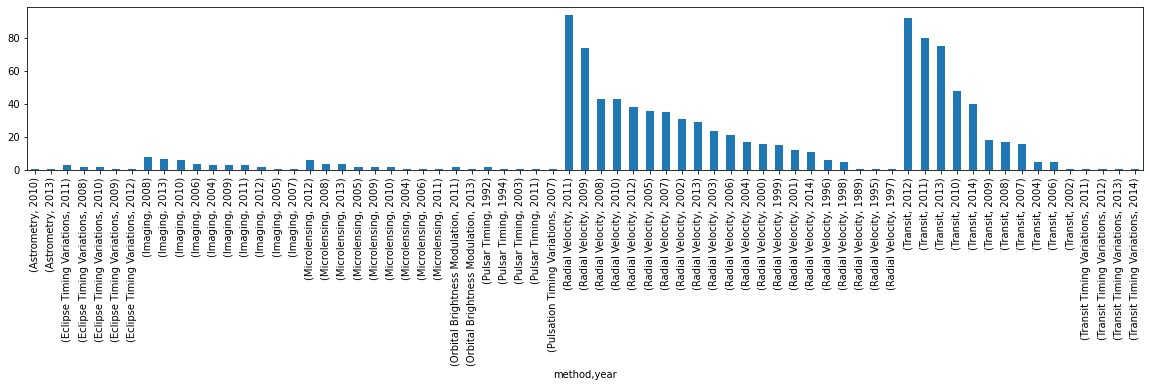

In [54]:
planets.groupby('method')['year'].value_counts().plot(kind='bar', figsize=(20, 3))

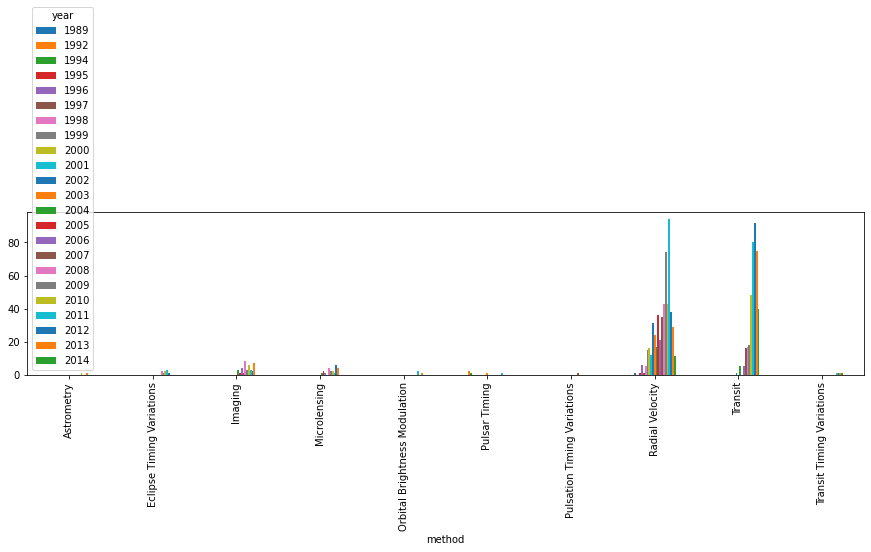

In [55]:
pd.crosstab(planets['method'], planets['year']).plot(kind='bar', figsize=(15, 3))

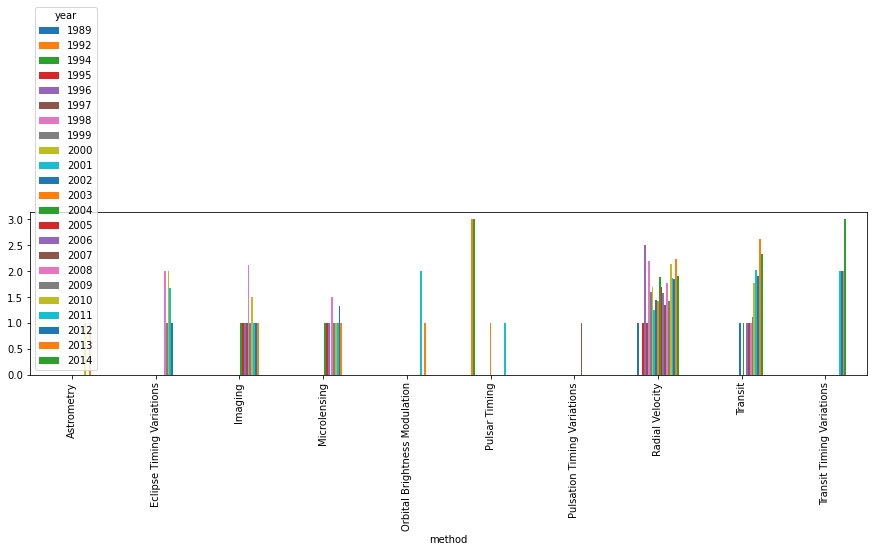

In [36]:
planets.pivot_table(values='number', index='method', columns='year').plot(kind='bar', figsize=(15, 3))

In [37]:
planets.columns

Index(['method', 'number', 'orbital_period', 'mass', 'distance', 'year'], dtype='object')

## 5. aggreate 표현

In [58]:
planets.groupby('method').distance.sum()

method
Astrometry                           35.75
Eclipse Timing Variations          1261.44
Imaging                            2166.91
Microlensing                      41440.00
Orbital Brightness Modulation      2360.00
Pulsar Timing                      1200.00
Pulsation Timing Variations           0.00
Radial Velocity                   27348.11
Transit                          134242.77
Transit Timing Variations          3313.00
Name: distance, dtype: float64

In [59]:
planets.pivot_table(values=['distance'], index=['method'], aggfunc=sum)

,distance
method,
Astrometry,35.75
Eclipse Timing Variations,1261.44
Imaging,2166.91
Microlensing,41440.00
Orbital Brightness Modulation,2360.00
Pulsar Timing,1200.00
Pulsation Timing Variations,0.00
Radial Velocity,27348.11
Transit,134242.77


In [61]:
planets.method.value_counts().sort_index()

Astrometry                         2
Eclipse Timing Variations          9
Imaging                           38
Microlensing                      23
Orbital Brightness Modulation      3
Pulsar Timing                      5
Pulsation Timing Variations        1
Radial Velocity                  553
Transit                          397
Transit Timing Variations          4
Name: method, dtype: int64

In [41]:
planets.groupby(['method'])['year'].value_counts().unstack().fillna(0).head(2)

year,1989,1992,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
method,,,,,,,,,,,,,,,,,,,,,
Astrometry,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
Eclipse Timing Variations,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1.0,2.0,3.0,1.0,0.0,0.0


In [42]:
planets.groupby(['method', 'number'])['year'].value_counts().unstack().fillna(0).head(3)

year                              1989  1992  1994  1995  1996  1997  1998  \
method                    number                                             
Astrometry                1        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Eclipse Timing Variations 1        0.0   0.0   0.0   0.0   0.0   0.0   0.0   
                          2        0.0   0.0   0.0   0.0   0.0   0.0   0.0   

year                              1999  2000  2001  ...  2005  2006  2007  \
method                    number                    ...                     
Astrometry                1        0.0   0.0   0.0  ...   0.0   0.0   0.0   
Eclipse Timing Variations 1        0.0   0.0   0.0  ...   0.0   0.0   0.0   
                          2        0.0   0.0   0.0  ...   0.0   0.0   0.0   

year                              2008  2009  2010  2011  2012  2013  2014  
method                    number                                            
Astrometry                1        0.0   0.0   1.0   0.0   0.0   1.0   0.0  
Eclipse Timing Variations 1        0.0   1.0   0.0   1.0   1.0   0.0   0.0  
                          2        2.0   0.0   2.0   2.0   0.0   0.0   0.0  

[3 rows x 23 columns]

### Aggregate, filter, transform, apply

The preceding discussion focused on aggregation for the combine operation, but there are more options available.
In particular, ``GroupBy`` objects have ``aggregate()``, ``filter()``, ``transform()``, and ``apply()`` methods that efficiently implement a variety of useful operations before combining the grouped data.

For the purpose of the following subsections, we'll use this ``DataFrame``:

In [69]:
#rng = np.random.RandomState(11)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,8
1,B,1,8
2,C,2,1
3,A,3,3
4,B,4,6
5,C,5,2


#### Aggregation

We're now familiar with ``GroupBy`` aggregations with ``sum()``, ``median()``, and the like, but the ``aggregate()`` method allows for even more flexibility.
It can take a string, a function, or a list thereof, and compute all the aggregates at once.
Here is a quick example combining all these:

In [70]:
df.groupby('key').aggregate([min, np.median, max])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    5.5   8
B       1    2.5   4     6    7.0   8
C       2    3.5   5     1    1.5   2

Another useful pattern is to pass a dictionary mapping column names to operations to be applied on that column:

In [71]:
df.groupby('key').aggregate({'data1': 'min',
                             'data2': 'max'})

,data1,data2
key,,
A,0,8
B,1,8
C,2,2


### Grouping example

As an example of this, in a couple lines of Python code we can put all these together and count discovered planets by method and by decade:

In [72]:
planets

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300000,7.10,77.40,2006
1,Radial Velocity,1,874.774000,2.21,56.95,2008
2,Radial Velocity,1,763.000000,2.60,19.84,2011
3,Radial Velocity,1,326.030000,19.40,110.62,2007
4,Radial Velocity,1,516.220000,10.50,119.47,2009
...,...,...,...,...,...,...
1030,Transit,1,3.941507,NaN,172.00,2006
1031,Transit,1,2.615864,NaN,148.00,2007
1032,Transit,1,3.191524,NaN,174.00,2007
1033,Transit,1,4.125083,NaN,293.00,2008


In [74]:
planets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method          1035 non-null   object 
 1   number          1035 non-null   int64  
 2   orbital_period  992 non-null    float64
 3   mass            513 non-null    float64
 4   distance        808 non-null    float64
 5   year            1035 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 48.6+ KB


In [76]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade

0       2000s
1       2000s
2       2010s
3       2000s
4       2000s
        ...  
1030    2000s
1031    2000s
1032    2000s
1033    2000s
1034    2000s
Name: year, Length: 1035, dtype: object

In [78]:
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


This shows the power of combining many of the operations we've discussed up to this point when looking at realistic datasets.
We immediately gain a coarse understanding of when and how planets have been discovered over the past several decades!

Here I would suggest digging into these few lines of code, and evaluating the individual steps to make sure you understand exactly what they are doing to the result.
It's certainly a somewhat complicated example, but understanding these pieces will give you the means to similarly explore your own data.

# End